In [8]:
# -*- coding: utf-8 -*-
import scipy.io as scio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [9]:
# w:权值矩阵
# a:神经网络内部节点
# x:神经网络外部节点
def feedforward(w,a,x):
    # 激活函数sigmoid
    f = lambda s: 1 / (1 + np.exp(-s)) 

    #将网络的内部及外部输入联合起来与权值矩阵进行加权叠加
    #这里使用的是矩阵运算使训练更加快捷
    w = np.array(w)
    temp = np.array(np.concatenate((a,x),axis=0))
    z_next = np.dot(w , temp)

    # 返回计算的下一层神经元的计算结果
    # 及未经过激活函数前的加权叠加结果
    return f(z_next), z_next

In [10]:
# w: 权值矩阵
# z: 当前层的未经过激活函数前的神经元值
# delta_next： 下一层的 δ
def backprop(w,z,delta_next):

    # sigmoid 激活函数
    f = lambda s: np.array(1 / (1 + np.exp(-s)))

    # 激活函数 sigmoid 的导数
    df = lambda s: f(s) * (1 - f(s))

    # 误差反向传播计算上一层的 δ 并返回
    delta = df(z) * np.dot(w.T,delta_next)    

    return delta

In [11]:
trainData = scio.loadmat('trainData.mat')
unlabeled_data = trainData['trainData']
unlabeled_data = unlabeled_data[:,:] / 255.

In [12]:
alpha = 5 # 学习步长
max_epoch = 500 # 训练得最大迭代次数
mini_batch = 100 # 在线学习批训练一次训练得次数
imgSize = 784 # 每张图片的大小，共784个像素

# 定义神经网络结构
# 第一列为外部节点（神经元）
# 第二列为内部节点，最后一层为网络输出
layer_struc = [[imgSize, 1],
               [0, 32],
               [0, imgSize]]
layer_num = 3

# 初始化权值矩阵
w = []
for l in range(layer_num-1):
    w.append(np.random.randn(layer_struc[l+1][1],sum(layer_struc[l])))

dataset_size = 500  # 训练数据集大小

# 定义神经网络的外部输入
# 虽然只有第一层外部输入
# 但是为了训练时代码的统一，也设置了最后两层空的外部输入
X = []
X.append(np.array(unlabeled_data[:,:]))
X.append(np.zeros((0,dataset_size)))
X.append(np.zeros((0,dataset_size)))

# 初始化误差反向传播时所需的δ
delta = []
for l in range(layer_num):
    delta.append([])

# 定义结果展示的参数 
# 每隔100个epoch展示一次自编码结果
# 加上第一行的原始图片展示
nRow = max_epoch / 100 + 1
nColumn = 10   # 每一行展示0-9十个数字
eachDigitNum = 50  # 每个数字都有50张训练图片

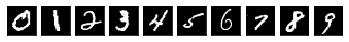

In [13]:
for iImg in range(nColumn):
    ax = plt.subplot(nRow, nColumn, iImg+1)
    plt.imshow(unlabeled_data[:,eachDigitNum * iImg + 1].reshape((28,28)).T, cmap= plt.cm.gray)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Autoencoder training start..
Learning epoch: 100 / 500
Learning epoch: 200 / 500
Learning epoch: 300 / 500
Learning epoch: 400 / 500
Learning epoch: 500 / 500


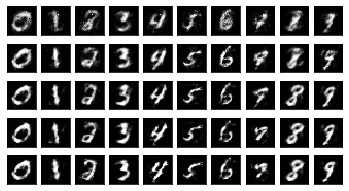

In [14]:
count = 0 # 迭代次数计步器
print('Autoencoder training start..')
for iter in range(max_epoch):

    # 定义shuffle时的下标
    # 可理解为每次训练时都将训练数据重新打乱一遍
    ind = list(range(dataset_size))
    random.shuffle(ind)

    a = [] # 网络内部神经元 
    z = [] # 网络节点的加权叠加结果
    z.append([])

    # 对神经网络开始批训练
    for i in range(int(np.ceil(dataset_size / mini_batch))):
        a.append(np.zeros((layer_struc[0][1], mini_batch)))
        x = []
        for l in range(layer_num):
            x.append( X[l][:,ind[i*mini_batch : min((i+1)*mini_batch, dataset_size)]])

        # 定义目标输出
        y = unlabeled_data[:,ind[i*mini_batch:min((i+1)*mini_batch,dataset_size)]]

        # 调用前向计算函数计算网络每一层节点的值
        for l in range(layer_num-1):
            a.append([])
            z.append([])
            a[l+1],z[l+1] = feedforward(w[l],a[l],x[l])

        # 根据最小二乘代价函数计算最后一层的δ
        # 即自编码器的实际输出与目标值的欧式距离
        delta[layer_num-1] = np.array(a[layer_num-1] - y) * np.array(a[layer_num-1])
        delta[layer_num-1] = delta[layer_num-1] * np.array(1-a[layer_num-1])

        # 误差反向传播过程
        # 调用backprop函数逐层反向计算 δ 值
        for l in range(layer_num-2, 0, -1):
            delta[l] = backprop(w[l],z[l],delta[l+1])

        for l in range(layer_num-1):
            dw = np.dot(delta[l+1], np.concatenate((a[l],x[l]),axis=0).T) / mini_batch
            w[l] = w[l] - alpha * dw

    count = count + 1  

    # 展示自编码器编码结果 
    if np.mod(iter+1,100) == 0 :
        b = []
        b.append(np.zeros((layer_struc[0][1],dataset_size)))

        for l in range(layer_num-1):
            tempA, tempZ = feedforward(w[l], b[l], X[l])                
            b.append(tempA)

        for iImg in range(nColumn):
            ax = plt.subplot(nRow,nColumn, iImg + nColumn * (iter+1)/100 + 1)
            dis_result = b[layer_num-1][:,eachDigitNum * iImg + 1].reshape(28,28).T
            plt.imshow(dis_result,cmap= plt.cm.gray) 
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        print('Learning epoch:', count, '/', max_epoch)

plt.show()